# Machine Learning II: Assignments 2
Leon Berghoff, Jiawei Li, Strahinja Trenkic, Otto Riess

In [41]:
import numpy as np
import pandas as pd
from bank_mkt import import_dataset, split_dataset, transform
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
# cosmetic options
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
rc = {"figure.figsize": (6.4, 4.8),
      "figure.dpi": 300,
      "axes.titlesize": "large",
      "axes.titleweight": "bold",
      "axes.titlepad": 12,
      "axes.titlelocation": "left"}
sns.set_theme(context="notebook", style="darkgrid", color_codes=True, rc=rc)

# Data Preparation

The bank marketing dataset was collected by Moro, Cortez, and Rita (2014) with marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be or not subscribed. The data is ordered by date ranging from May 2008 to November 2010.

In [33]:
bank_mkt = import_dataset("BankMarketing.csv")

func_transformer = FunctionTransformer(transform)

num_features = ["month",
                "day_of_week",
                "campaign",
                "previous",
                "emp.var.rate",
                "cons.price.idx",
                "cons.conf.idx",
                "euribor3m",
                "nr.employed"]

standard_scaler = ColumnTransformer([("scaler", StandardScaler(), num_features)], remainder="passthrough")

preprocessor = make_pipeline(func_transformer, standard_scaler)

X_train, y_train, X_test, y_test, *_ = split_dataset(bank_mkt, preprocessor, test_size=0.8)

# Metrics

The dataset is clearly imbalanced where positive results are far less than negative results. Banks want to improve both recall and precision rates for marketing compains while the true negative rate is not as important.

In [34]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([2038,  660]))

A receiver operating characteristic (ROC) is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting TPR against FPR at various threshold settings. Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. Both metrics work well with imbalaced dataset while AP sets higher weights for true positives.

$$
AP = \sum_{n} (REC_n - REC_{n-1})PRE_n
$$

Our goal is to maximize the area under ROC and AP curve.

In [38]:
names = ["Constant Prediction",
         "Random Prediction",
         "K-Nearest Neighbors",
         "Linear SVM",
         "Decision Tree",
         "Logistic Regression"]

clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        KNeighborsClassifier(n_neighbors=10),
        SGDClassifier(loss="hinge", class_weight="balanced"),
        DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
        LogisticRegression(class_weight="balanced")]

n = len(names)

y_pred = {}
for name, clf in zip(names, clfs):
    y_pred[name] = cross_val_predict(clf, X_train, y_train, cv=5, n_jobs=-1)

y_score = {}

y_threshold = {}

for name, clf in zip(names, clfs):
    if hasattr(clf, "decision_function"):
        response_method = "decision_function"
    else:
        response_method = "predict_proba"
        
    y_score[name] = cross_val_predict(clf,
                                      X_train,
                                      y_train,
                                      cv=5,
                                      n_jobs=-1,
                                      method=response_method)
    
    if name == "Logistic Regression":
        # For logistic regression, the hyperplane refered in the decision function is b_0+b_1x_1+...b_kx_k.
        # When hyperplane is 0, the probablity is 0.5,
        # therefore the threshold of decision function for logistic regression is 0.
        # https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun
        y_threshold[name] = 0
    elif name == "Linear SVM":
        y_threshold[name] = 0
    else:
        y_score[name] = y_score[name][:, 1]
        y_threshold[name] = 0.5

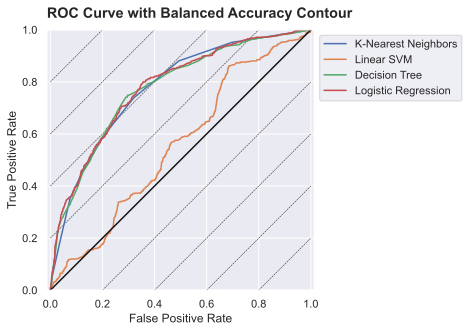

In [39]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def bacc(x, y):
    return (1-x+y)/2

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x, y)
Z = bacc(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    fpr, tpr, thresholds = roc_curve(y_train, y_score[name])
    ax.plot(fpr, tpr, label=name)
    
ax.plot([0, 1], [0, 1], color="k")
ax.axis("equal")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel="False Positive Rate",
       ylabel="True Positive Rate",
       title="ROC Curve with Balanced Accuracy Contour");

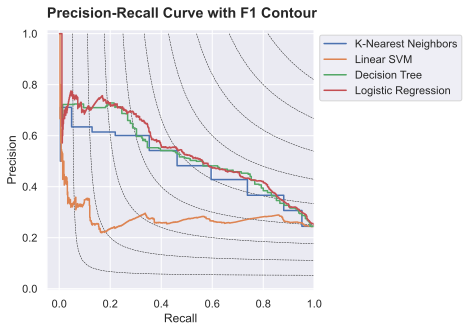

In [43]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def f1(x, y):
    return 2*x*y/(x+y)

x = np.linspace(0.01,1)
y = np.linspace(0.01,1)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, precisions, drawstyle="steps-post", label=name)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis("equal")
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve with F1 Contour")

# Hyperparameters

In [7]:
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [8]:
poly_svm = SVC(kernel="poly", class_weight="balanced", random_state=42)

poly_distributions = {"C": loguniform(1e0, 1e2),
    "degree": [1, 2, 3],
    "gamma": ["scale"],
    }

poly_search = RandomizedSearchCV(poly_svm,
    poly_distributions,
    scoring="average_precision",
    cv=5,
    n_jobs=-1,
    n_iter=6)

poly_fit = poly_search.fit(X_train, y_train)
poly_results = poly_fit.cv_results_
poly_best_params = poly_fit.best_params_
poly_best_score = poly_fit.best_score_

print(f"best parameters found: {poly_best_params}, with mean test score: {poly_best_score}")

best parameters found: {'C': 52.38469716655002, 'degree': 1, 'gamma': 'scale'}, with mean test score: 0.5105652077905866
